In [23]:
import data_retrieval_utils as dru
import fsspec
import fv3viz
from matplotlib.colors import LogNorm
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from run_dict import RUN_DICT, BASELINE_ALG, ML_ONLY_ALG, OCSVM_DEFAULT
from scipy.interpolate import interp1d
import xarray as xr

Reference pressure levels:

In [2]:
ak = [
  300, 646.715942382812, 1045.22229003906, 1469.18811035156,
    1897.82861328125, 2325.384765625, 2754.3955078125, 3191.29443359375,
    3648.33203125, 4135.67529296875, 4668.2822265625, 5247.93994140625,
    5876.2705078125, 6554.71630859375, 7284.521484375, 8066.73779296875,
    8902.1875, 9791.482421875, 10734.9853515625, 11626.2529296875,
    12372.123046875, 12990.4072265625, 13496.29296875, 13902.765625,
    14220.982421875, 14460.5810546875, 14629.9306640625, 14736.3271484375,
    14786.1748046875, 14785.1064453125, 14738.1181640625, 14649.65625,
    14523.6982421875, 14363.81640625, 14173.2412109375, 13954.9072265625,
    13711.4775390625, 13445.3955078125, 13158.904296875, 12854.0693359375,
    12532.80078125, 12196.8544921875, 11847.880859375, 11487.3916015625,
    11116.8232421875, 10737.484375, 10350.625, 9957.39453125, 9558.875,
    9156.0693359375, 8749.921875, 8341.3154296875, 7931.06494140625,
    7519.94189453125, 7108.64794921875, 6698.28076171875, 6290.0068359375,
    5884.984375, 5484.3720703125, 5089.31884765625, 4700.96044921875,
    4320.4208984375, 3948.80688476562, 3587.201171875, 3236.66625976562,
    2898.23681640625, 2572.91235351562, 2261.66650390625, 1965.42407226562,
    1685.07934570312, 1421.47912597656, 1175.41882324219, 947.651550292969,
    738.868774414062, 549.712951660156, 380.762573242188, 232.541656494141,
    105.481033325195, -0.000838190317153931, 0]
bk = [
  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    0.00106594723183662, 0.00412866193801165, 0.00900663062930107,
    0.015542627312243, 0.0235992092639208, 0.033054806292057,
    0.043801199644804, 0.05574094876647, 0.0687855407595634,
    0.0828534662723541, 0.0978698134422302, 0.113764345645905,
    0.130471020936966, 0.147927477955818, 0.166074603796005,
    0.184855818748474, 0.204216599464417, 0.224105268716812,
    0.24447163939476, 0.265267163515091, 0.286444991827011,
    0.307960391044617, 0.329770147800446, 0.351832032203674,
    0.374106198549271, 0.396553158760071, 0.419136375188828,
    0.441819369792938, 0.464568197727203, 0.487349987030029,
    0.510133802890778, 0.532889664173126, 0.555589437484741,
    0.578206658363342, 0.600715756416321, 0.623093605041504,
    0.645294427871704, 0.6672682762146, 0.688964784145355, 0.710333287715912,
    0.73132312297821, 0.751883804798126, 0.771965146064758,
    0.791517317295074, 0.810491323471069, 0.828839004039764,
    0.846513032913208, 0.863467633724213, 0.879658281803131,
    0.89504212141037, 0.909577906131744, 0.923226416110992,
    0.935950636863708, 0.947715699672699, 0.958489239215851,
    0.968241274356842, 0.976944744586945, 0.98457533121109,
    0.991112649440765, 0.996537208557129, 1]

# reference pressure levels in hPa assuming 1000hPa surface pressure
plev = np.array(ak)/100 + np.array(bk) * 1000  
plev_mid = 0.5 * (plev[:-1] + plev[1:])

In [3]:
f = interp1d(plev_mid, range(0, 79), fill_value='extrapolate')
tick_labels = [3, 100, 300, 500, 700, 850, 1000]
tick_indices = f(tick_labels)

In [10]:
states = dru.get_states({BASELINE_ALG: RUN_DICT[BASELINE_ALG], ML_ONLY_ALG: RUN_DICT[ML_ONLY_ALG]})
states_ml = states[ML_ONLY_ALG]
states_bl = states[BASELINE_ALG]

In [15]:
reference_data_url = "gs://vcm-ml-experiments/n2f-pire-sfc-updates/2022-01-21/nudged-run/fv3gfs_run/reference_state.zarr"
states_ref = xr.open_zarr(fsspec.get_mapper(reference_data_url))
start_time = states_ml.time.min().item()
end_time = states_ml.time.max().item()
states_ref = states_ref.sel(time=slice(start_time, end_time)).rename({
    "air_temperature_reference": "air_temperature",
    "specific_humidity_reference": "specific_humidity"
})

In [16]:
nd_paths = {
    # "minmax_t": "gs://vcm-ml-experiments/claytons/2022-07-13/oos-test/novelty",
    # "minmax_tq": "gs://vcm-ml-experiments/claytons/2022-07-20/tq-combined-nd-trial-2/trained_models/minmax",
    # "ocsvm_t_large_gamma": "gs://vcm-ml-experiments/claytons/2022-07-18/ocsvm-gamma-trial-1/trained_models/ocsvm-large",
    # OCSVM_LARGE_GAMMA: "gs://vcm-ml-experiments/claytons/2023-02-13/tq-additional-ocsvms-trial-3/trained_models/ocsvm-tq-gamma-8_79-nu-4e-6",
    OCSVM_DEFAULT: "gs://vcm-ml-experiments/claytons/2022-08-09/tq-combined-nd-trial-1/trained_models/ocsvm-larger-gamma",
    # OCSVM_SMALL_GAMMA: "gs://vcm-ml-experiments/claytons/2023-02-08/tq-additional-ocsvms-trial-2/trained_models/ocsvm-tq-gamma-2_79-nu-5e-3",
    # OCSVM_SMALLEST_GAMMA: "gs://vcm-ml-experiments/claytons/2023-02-08/tq-additional-ocsvms-trial-2/trained_models/ocsvm-tq-gamma-1_79-nu-5e-3",
}
nd_names = {
    # OCSVM_LARGE_GAMMA: r"$\eta_{\mathrm{Tq, OCSVM}}, \gamma = \frac{8}{79}$",
    OCSVM_DEFAULT: r"$\eta_{\mathrm{Tq, OCSVM}}, \gamma = \frac{4}{79}$",
    # OCSVM_SMALL_GAMMA: r"$\eta_{\mathrm{Tq, OCSVM}}, \gamma = \frac{2}{79}$",
    # OCSVM_SMALLEST_GAMMA: r"$\eta_{\mathrm{Tq, OCSVM}}, \gamma = \frac{1}{79}$",
    # "ocsvm_t_large_gamma": r"$\eta_{\mathrm{T, OCSVM}}, \gamma = \frac{4}{79}$",
    # "ocsvm_t_small_gamma": r"$\eta_{\mathrm{T, OCSVM}}, \gamma = \frac{1}{4 \cdot 79}$",
    # "minmax_t": r"$\eta_{\mathrm{T, minmax}}$",
    # "minmax_tq": r"$\eta_{\mathrm{Tq, minmax}}$",
}

### Map of novelty fractions

In [17]:
diags_default = dru.get_offline_diags(nd_paths[OCSVM_DEFAULT], ML_ONLY_ALG)

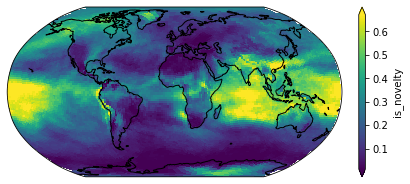

In [18]:
fig, subplots, _, _, _  = fv3viz.plot_cube(
    diags_default.merge(dru.GRID).mean("time"),   
    "is_novelty",
)

### Barcode plots

In [19]:
time_sl = slice("2020-01-19", "2020-05-10")

In [25]:
def barcode_plot(x, y, tile, is_reference):
    lat = states_ml.latitude.isel(time=0, x=x, y=y, tile=tile).values
    lon = states_ml.longitude.isel(time=0, x=x, y=y, tile=tile).values

    _, (ax1, ax2, ax3) = plt.subplots(3,1,sharex=True,figsize=(8, 12),constrained_layout=True,gridspec_kw={'height_ratios': [5, 5, 1]})

    temps = states_ml.air_temperature.where(states_ml.time.dt.hour == 0, drop=True).sel(time=time_sl)
    humids = states_ml.specific_humidity.where(states_ml.time.dt.hour == 0, drop=True).sel(time=time_sl)
    run_name = "bad-seed ML-corrected"

    if is_reference:
        temps = states_ref.air_temperature
        humids = states_ref.specific_humidity
        run_name = "reference"
    else:
        temps = states_ml.air_temperature.where(states_ml.time.dt.hour == 0, drop=True).sel(time=time_sl)
        humids = states_ml.specific_humidity.where(states_ml.time.dt.hour == 0, drop=True).sel(time=time_sl)
        run_name = "bad-seed ML-corrected"

    temps.isel(x=x, y=y, tile=tile).plot(ax=ax1, x = "time", y = "z", yincrease=False)
    ax1.set_title(f"Temperature at ({lat * 180 / math.pi: .2f} Lat, {lon * 180 / math.pi: .2f} Lon), {run_name} run")
    ax1.set_yticks(tick_indices)
    ax1.set_yticklabels(tick_labels)
    ax1.set_ylabel('Air temperature [K]')

    xr.ufuncs.maximum(1e-8, humids.isel(x=x, y=y, tile=tile)).plot(x = "time", y = "z", norm=LogNorm(), ax=ax2, yincrease=False)
    ax2.set_title(f"Specific humidity at ({lat * 180 / math.pi: .2f} Lat, {lon * 180 / math.pi: .2f} Lon), {run_name} run")
    ax2.set_yticks(tick_indices)
    ax2.set_yticklabels(tick_labels)
    ax2.set_ylabel('Reference pressure [hPa]')

    if not is_reference:
        n = len(nd_paths)
        buffer = 1 / 8 / (n + 1)
        yticks = []
        labels = []

        for i, (name, nd_path) in enumerate(nd_paths.items()):
            is_novelty = dru.get_offline_diags(nd_path, ML_ONLY_ALG).isel(x=x, y=y, tile=tile).is_novelty.sel(time=time_sl)
            ax3.imshow(
                is_novelty.to_numpy().reshape(1, -1),
                cmap='binary',
                aspect='auto',
                extent=(ax2.get_xlim()[0],ax2.get_xlim()[1], 1-(i+1)/n+buffer, 1-i/n-buffer)
            )
            yticks.append(1 - (2 * i + 1) / n / 2)
            labels.append(nd_names[name])
        ax3.set_ylim([0, 1])
        ax3.set_yticks(yticks)
        ax3.set_yticklabels(labels)
        ax3.set_title("Novelty classification")

    plt.show()

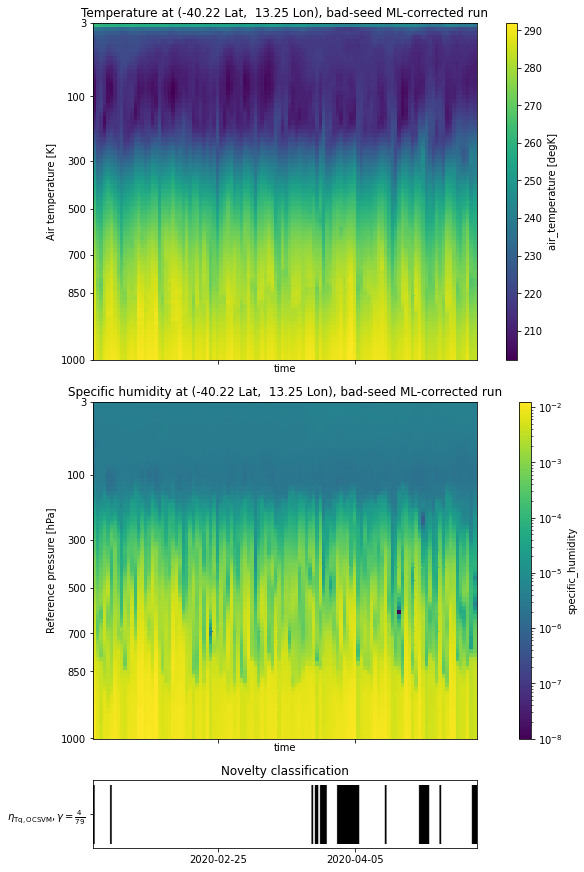

In [27]:
for _ in range(1):
    rand_tile = np.random.randint(0, 6, 1)[0]
    rand_x = np.random.randint(0, 48, 1)[0]
    rand_y = np.random.randint(0, 48, 1)[0]
    barcode_plot(rand_x, rand_y, rand_tile, is_reference=False)


In [28]:
def find_coords_by_lat_lon(lat, lon):
    """
    Given a target lat/lon coord, finds a (tile, x, y) pair nearby
    """
    dist = 4 * (states_ml.latitude.isel(time=0) - lat * math.pi / 180)**2 + (states_ml.longitude.isel(time=0) - lon * math.pi / 180)**2
    min_coords = np.where(dist == dist.min())
    tile = min_coords[0][0]
    x = min_coords[2][0]
    y = min_coords[1][0]
    lat_close = states_ml.latitude.isel(x=x, y=y, tile=tile, time=0).values * 180 / math.pi
    lon_close = states_ml.longitude.isel(x=x, y=y, tile=tile, time=0).values * 180 / math.pi
    print(f"Closest cell to ({lat}, {lon}): ({lat_close}, {lon_close})")
    return tile, x, y

Closest cell to (23.13, 113.26): (23.281307362632155, 112.49023415215534)


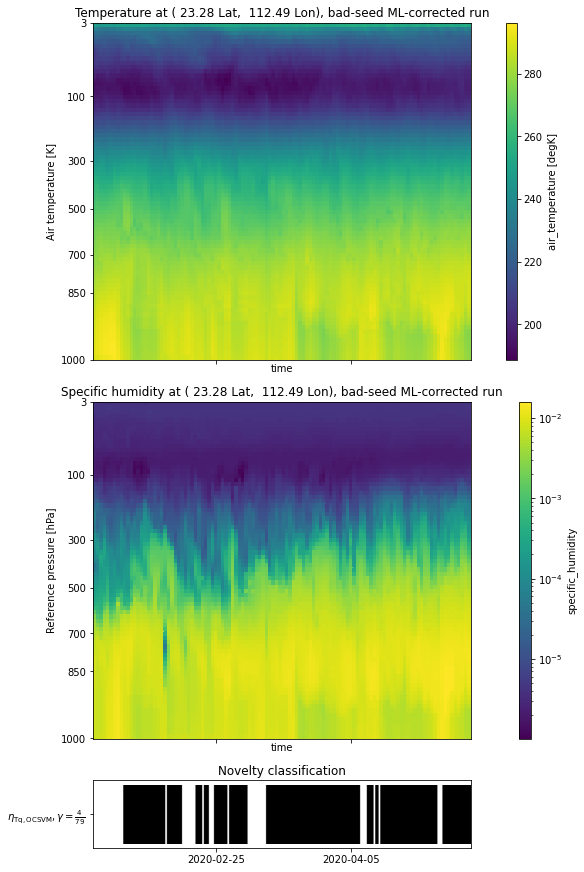

In [29]:
# search over Guangzhou
tile, x, y = find_coords_by_lat_lon(23.13, 113.26)
barcode_plot(x, y, tile, is_reference=False)
barcode_plot(x, y, tile, is_reference=True)

In [ ]:
# search over Indian Ocean
tile, x, y = find_coords_by_lat_lon(0, 75)
barcode_plot(x, y, tile, is_reference=False)
barcode_plot(x, y, tile, is_reference=True)